### Fourier Transform drawings

In [222]:
import cv2
import numpy as np
from math import tau
from time import time as tic

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.animation as animation

import networkx as nx

from scipy.spatial import distance_matrix
from scipy.fft import fft, fftfreq
# from scipy import interpolate
# from scipy.integrate import quad_vec

%matplotlib inline

## Load an image
I have preprocessed the image to highlight the outline. But one can probably get a similar results using `cv2` toolbox.

In [46]:
img = cv2.imread("./images/andrew_pp.png") 
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(imgray, (7, 7), 0)

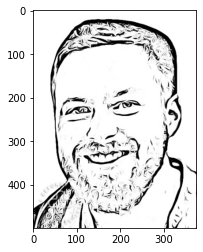

In [47]:
plt.imshow(img)

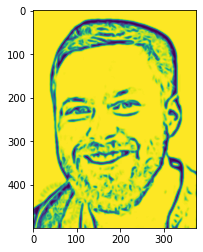

In [48]:
plt.imshow(blurred)

In [49]:
ret, thresh = cv2.threshold(imgray, 180, 255, 0)

Text(0.5, 1.0, 'Simple Thresholding')

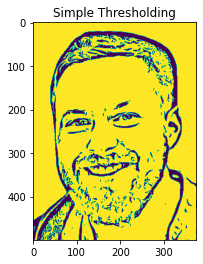

In [50]:
plt.imshow(thresh)
plt.title("Simple Thresholding")

In [51]:
(T, thresh) = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

Text(0.5, 1.0, 'Otsu Thresholding')

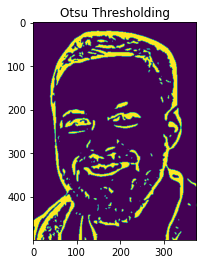

In [52]:
plt.imshow(thresh)
plt.title("Otsu Thresholding")

Text(0.5, 1.0, 'Mean Adaptive Thresholding')

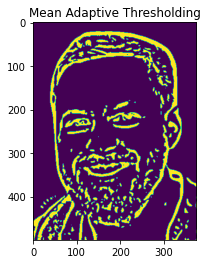

In [53]:
# instead of manually specifying the threshold value, we can use
# adaptive thresholding to examine neighborhoods of pixels and
# adaptively threshold each neighborhood
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)
plt.imshow(thresh)
plt.title("Mean Adaptive Thresholding")

Text(0.5, 1.0, 'Gaussian Adaptive Thresholding')

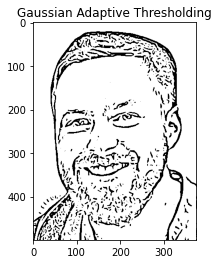

In [54]:
thresh = cv2.adaptiveThreshold(blurred, 255,
	cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 2)
plt.imshow(thresh, cmap='Greys')
plt.title("Gaussian Adaptive Thresholding")

That looks good enough!

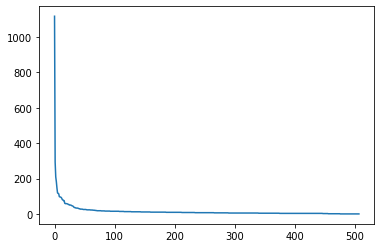

In [55]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.plot([len(c) for c in sorted(contours, key=lambda x: -len(x))])

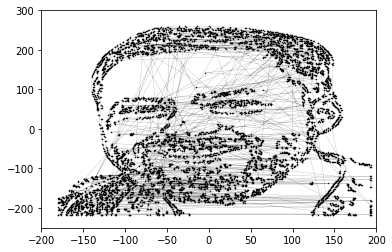

In [60]:
stacked_contours = np.vstack(sorted(contours, key=lambda x: -len(x)))
verts = [ tuple(coord) for coord in stacked_contours.squeeze() ]
codes = [ Path.MOVETO ] + [ Path.MOVETO ] * (len(verts)-1)
path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*verts)
xs = np.asarray(xs) - np.mean(xs)
ys = - np.asarray(ys) + np.mean(ys)
pos = np.vstack((xs,ys)).T

ax.plot(xs, ys, '.-', lw=.1, color='black', ms=1)
ax.set_xlim(-200, 200)
ax.set_ylim(-250, 300)
plt.show()

See the lines? It is because there's no order in the points. We have to somehow enforce it.

# Sorting data as a tree

We first find a connected tree over all the points, then travel that tree. Edges are weighted according to the distance between points. So, the farther two points are from one another, the larger the weight between them would be. Now, if you are the salesman of [the salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem), you would like to hop between cities so that your travelling cost is minimized. This is exactly what we want.

In [64]:
def mst_traversal(points):
    # Create a distance matrix from the points
    dist_matrix = distance_matrix(points, points)
    
    # Create a graph from the distance matrix
    G = nx.Graph()
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            G.add_edge(i, j, weight=dist_matrix[i, j])
    
    # Compute the Minimum Spanning Tree (MST) using Kruskal's algorithm
    mst = nx.minimum_spanning_tree(G, weight='weight')
    return mst

mst = mst_traversal(pos)

In [166]:
# Perform DFS to get the pre-order traversal of the MST
start_node = 1020  # You can start from any node
preorder_traversal = list(nx.dfs_preorder_nodes(mst, start_node))

# Create the ordered path based on the traversal
ordered_points = np.array([pos[i] for i in preorder_traversal])

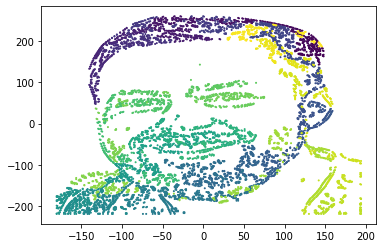

In [167]:
Xs, Ys = ordered_points.T
plt.scatter(Xs, Ys, s=1, c=np.arange(len(Xs)))

In [20]:
# # Plot the MST and traversal
# plt.figure(figsize=(8,8))
# nx.draw(mst, pos={i: pos[i] for i in range(len(pos))}, with_labels=True, node_color='lightblue', node_size=1)
# plt.scatter(pos[:, 0], pos[:, 1], color='red')
# plt.show()

### Compute the Fourier coefficients

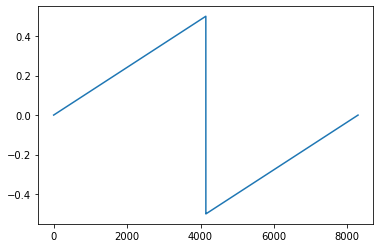

In [172]:
zs = ordered_pos[:,0]+1j*ordered_pos[:,1]
zs = np.array(zs)
ts = np.linspace(0, 2*np.pi, len(zs))
Z = fft(zs)
freqs = fftfreq(len(zs))
t_list = np.linspace(0, tau, len(zs)) # corresponding times
plt.plot(freqs) # just to check the order

In [107]:
# depricated from the orignial repo. Too slow

# #result = quad_vec(lambda x: f(x, ...), a_min, b_min)
# def compute_cn(f, n):
#     coef = 1/tau*quad_vec(
#         # lambda t: f(t, t_list, xs, ys)*np.exp(-n*t*1j), 
#         lambda t: f(t)*np.exp(-n*t*1j), 
#         0, 
#         tau, 
#         limit=100, 
#         full_output=False)[0]
#     return coef

# def f(t, t_list=t_list, xs=ordered_pos[:,0], ys=ordered_pos[:,1]):
#     return np.interp(t, t_list, xs + 1j*ys)

# N = 50
# coefs = [ (compute_cn(f, 0), 0) ] + [ (compute_cn(f, j), j) for i in range(1, N+1) for j in (i, -i) ]
# coefs

In [199]:
len(Z)

8292

In [216]:
N = 500# int(len(Z)//4)
Coefs = [ (Z[0]/len(Z), 0) ] + [(Z[j]/len(Z),j) for i in range(1, N+1) for j in (i,-i)]
Coefs

[((3.5115824061081655e-15-2.0812423982321893e-14j), 0),
 ((-6.2037093468462565+76.59254647263542j), 1),
 ((64.99568454206141+56.290882157177776j), -1),
 ((-12.427510851087197+36.046022577690096j), 2),
 ((-18.137855081809853+79.35053337927127j), -2),
 ((-44.720974657155956-27.118755170136172j), 3),
 ((-16.073112497940503+20.955769573521607j), -3),
 ((18.70451793055294-36.6982468886637j), 4),
 ((0.9802596821623272-2.572708945044637j), -4),
 ((30.588941431197664-9.78485050151558j), 5),
 ((-27.410202300535087+9.031000569997971j), -5),
 ((-5.650099709045626+8.582755822863021j), 6),
 ((1.1160524935816967-5.003331162536973j), -6),
 ((2.497364731383135-10.418730439341921j), 7),
 ((-8.52096675234458+11.734176810571881j), -7),
 ((1.385190533589408-3.2494921481966785j), 8),
 ((21.684450538169855+13.941228739561668j), -8),
 ((-7.017816894371947+1.8419413544896797j), 9),
 ((-1.448410844731423-6.70146933688906j), -9),
 ((0.9972175473124235-7.349891305153431j), 10),
 ((-11.83179309307827+15.580206003

In [217]:
len(Coefs)

1001

In [224]:
# utilities
def get_circle_coords(center, r, N=50):
    theta = np.linspace(0, tau, N)
    x, y = center[0] + r * np.cos(theta), center[1] + r * np.sin(theta)
    return x, y

def get_next_pos(c, fr, t=0.1, drawing_time = 1):
    angle = (fr * tau * t) / drawing_time
    return c * np.exp(1j*angle)


def plot_andrew(Z, N=None):
    
    if N is None:
        N = int(len(Z)//2)

    Coefs = [ (Z[0]/len(Z), 0) ] + [(Z[j]/len(Z),j) for i in range(1, N+1) for j in (i,-i)]

    
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white') # a hack to get white background
    # circles = [ax.plot([], [], 'b-', linewidth=.05)[0] for i in range(-N, N+1)]
    circle_lines = [ax.plot([], [], 'g-', linewidth=1)[0] for i in range(-N, N+1)]
    drawing, = ax.plot([], [], 'b-', linewidth=.5, marker='.', markersize=5)
    
    # to fix the size of figure so that the figure does not get cropped/trimmed
    ax.set_xlim(-200, 200)
    ax.set_ylim(-250, 300)
    
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    fig.set_size_inches(15, 15)
       
    # initializing empty values
    # for x and y co-ordinates
    draw_x, draw_y = [], []
       
    # animation function 
    def animate(i, coefs, time): 
        # t is a parameter which varies
        # with the frame number
        t = time[i]
        
        coefs = [ (get_next_pos(c, fr, t=t), fr) for c, fr in coefs ]
        center = (0, 0)
        #print(f"frame : {i}")
        for i, elts in enumerate(coefs) :
            c, fr = elts
            r = np.linalg.norm(c)
            #print(f"coef : {c} --- r  : {r} --- theta : {np.angle(c)}")
            # x, y = get_circle_coords(center=center, r=r, N=50)
            circle_lines[i].set_data([center[0], center[0]+np.real(c)], [center[1], center[1]+np.imag(c)])
            # circles[i].set_data(x, y) 
            center = (center[0] + np.real(c), center[1] + np.imag(c))
        
        # center points now are points from last circle
        # these points are used as drawing points
        draw_x.append(center[0])
        draw_y.append(center[1])
    
        # draw the curve from last point
        drawing.set_data(draw_x, draw_y)
       
    # calling the animation function 
    drawing_time = 1
    frames = N
    time = np.linspace(0, drawing_time, num=frames)    
    anim = animation.FuncAnimation(fig, animate, frames = frames, interval = 5, fargs=(Coefs, time)) 
       
    # saves the animation in our desktop
    anim.save(f'animations/andrew_{N}.mp4', writer = 'ffmpeg', fps = 36)

N = 10 took 0.2071535587310791 seconds.
N = 50 took 1.0851361751556396 seconds.
N = 100 took 2.9608452320098877 seconds.
N = 500 took 49.226067543029785 seconds.
N = None took 3127.0703291893005 seconds.


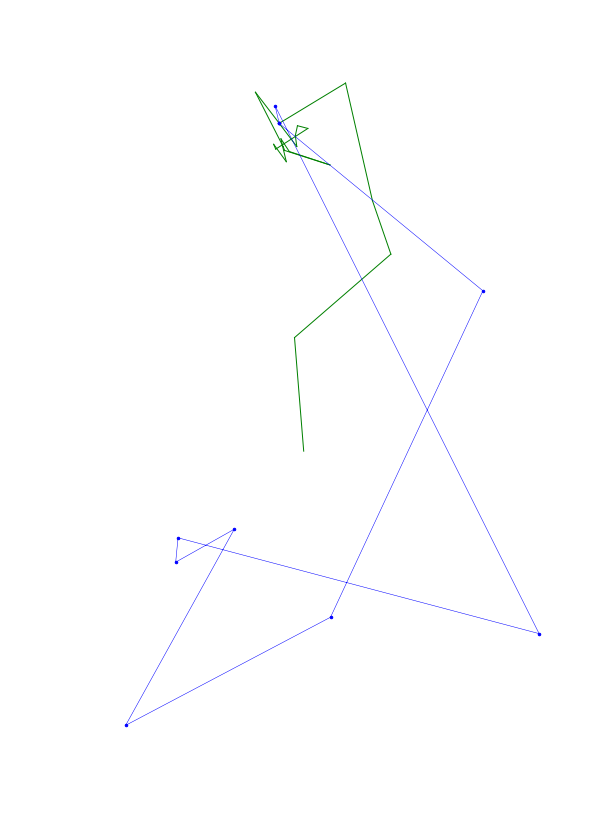

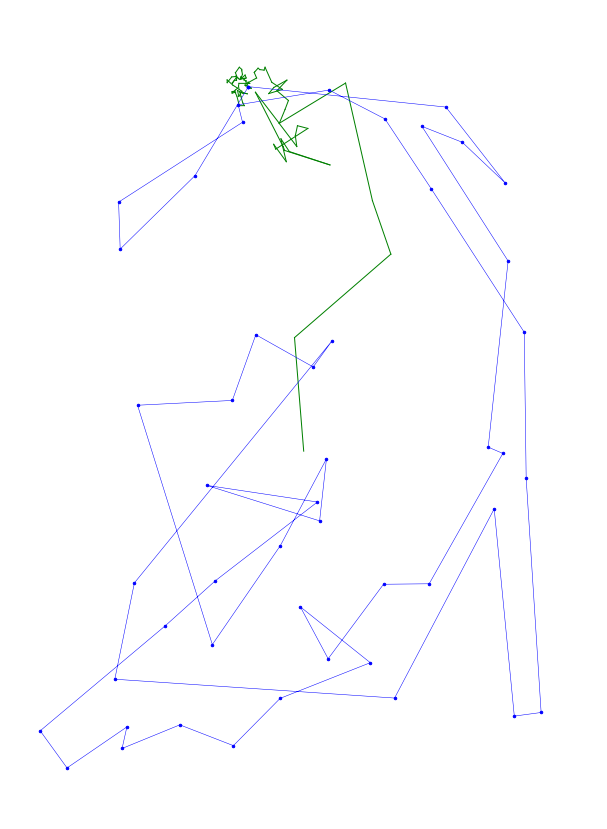

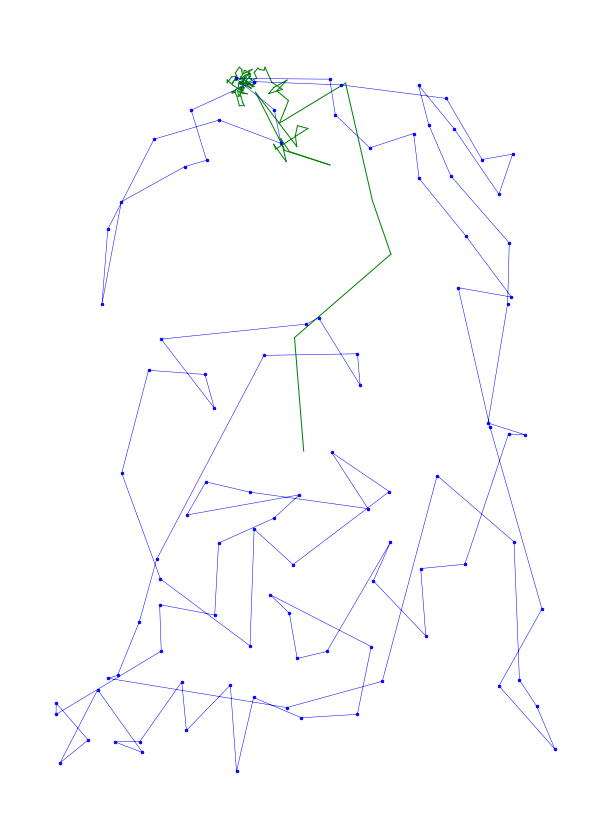

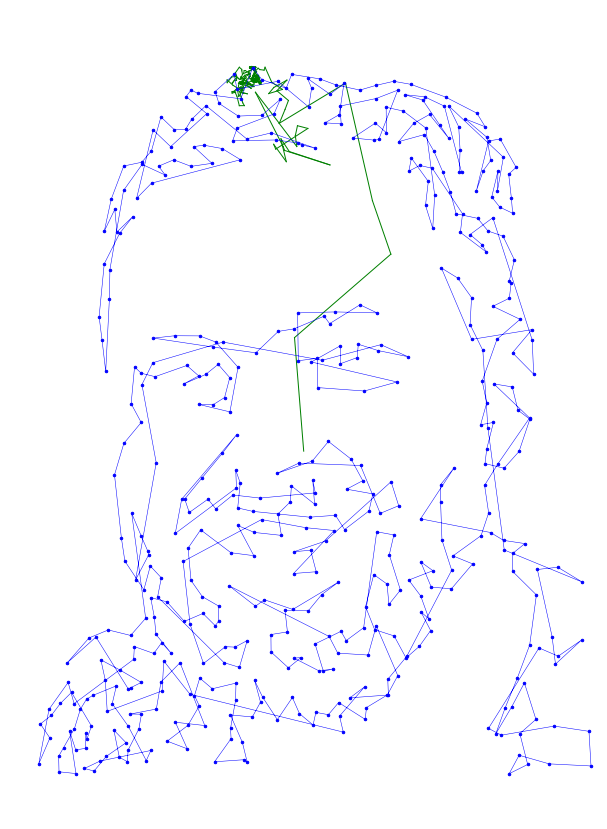

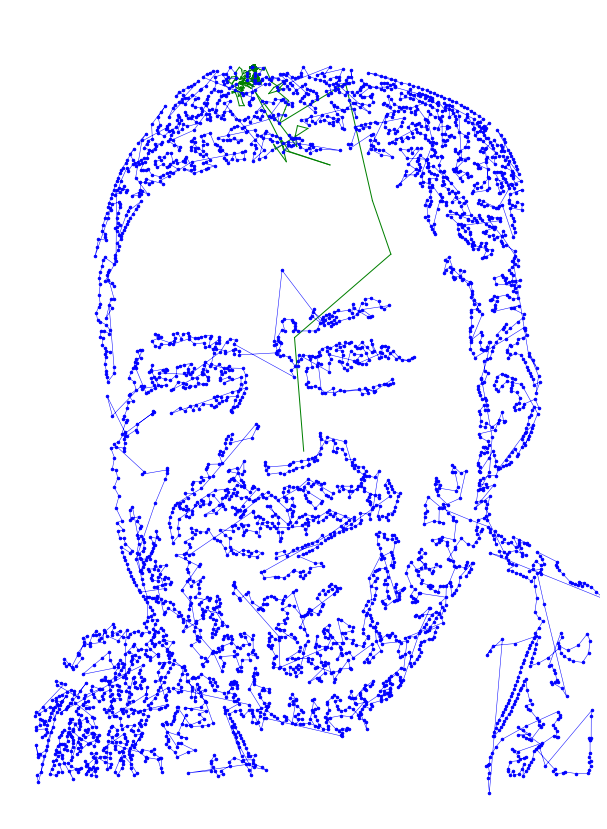

In [225]:
start = tic()
for N in [10, 50, 100, 500, None]:
    plot_andrew(Z, N)
    print(f'N = {N} took {tic()-start} seconds.')
    start = tic()

In [221]:
# # creating a blank window
# # for the animation 

# fig, ax = plt.subplots()
# fig.patch.set_facecolor('white') # a hack to get white background
# # circles = [ax.plot([], [], 'b-', linewidth=.05)[0] for i in range(-N, N+1)]
# circle_lines = [ax.plot([], [], 'g-', linewidth=1)[0] for i in range(-N, N+1)]
# drawing, = ax.plot([], [], 'b-', linewidth=.5, marker='.', markersize=5)

# # to fix the size of figure so that the figure does not get cropped/trimmed
# ax.set_xlim(-200, 200)
# ax.set_ylim(-250, 300)

# ax.set_axis_off()
# ax.set_aspect('equal')

# fig.set_size_inches(15, 15)
   
# # initializing empty values
# # for x and y co-ordinates
# draw_x, draw_y = [], []
   
# # animation function 
# def animate(i, coefs, time): 
#     # t is a parameter which varies
#     # with the frame number
#     t = time[i]
    
#     coefs = [ (get_next_pos(c, fr, t=t), fr) for c, fr in coefs ]
#     center = (0, 0)
#     #print(f"frame : {i}")
#     for i, elts in enumerate(coefs) :
#         c, fr = elts
#         r = np.linalg.norm(c)
#         #print(f"coef : {c} --- r  : {r} --- theta : {np.angle(c)}")
#         # x, y = get_circle_coords(center=center, r=r, N=50)
#         circle_lines[i].set_data([center[0], center[0]+np.real(c)], [center[1], center[1]+np.imag(c)])
#         # circles[i].set_data(x, y) 
#         center = (center[0] + np.real(c), center[1] + np.imag(c))
    
#     # center points now are points from last circle
#     # these points are used as drawing points
#     draw_x.append(center[0])
#     draw_y.append(center[1])

#     # draw the curve from last point
#     drawing.set_data(draw_x, draw_y)
   
# # calling the animation function 
# drawing_time = 1
# frames = N
# time = np.linspace(0, drawing_time, num=frames)    
# anim = animation.FuncAnimation(fig, animate, frames = frames, interval = 5, fargs=(Coefs, time)) 
   
# # saves the animation in our desktop
# anim.save(f'andrew_{N}.mp4', writer = 'ffmpeg', fps = 36)